# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = '/Users/michaelwransky/Documents/SDCND/traffic-signs/traffic-signs-data/train.p'
testing_file = '/Users/michaelwransky/Documents/SDCND/traffic-signs/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np
# TODO: number of training examples
n_train = y_train.shape[0]

# TODO: number of testing examples
n_test = y_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


/Users/michaelwransky/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/Users/michaelwransky/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc", line #512
  (fname, cnt))


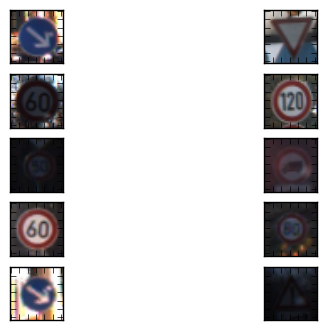

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualize a random subset of the images
# create an array of indices the same size as y_train
indx = np.arange(y_train.shape[0])
# shuffle the indices
np.random.shuffle(indx)
# create subplot and fill with images
f, axarr = plt.subplots(5, 2)
for i in range(5):
    for j in range(2):
        axarr[i, j].imshow(X_train[indx[j+5*i]])
        plt.setp(axarr[i,j].get_xticklabels(), visible=False)
        plt.setp(axarr[i,j].get_yticklabels(), visible=False)
plt.show()

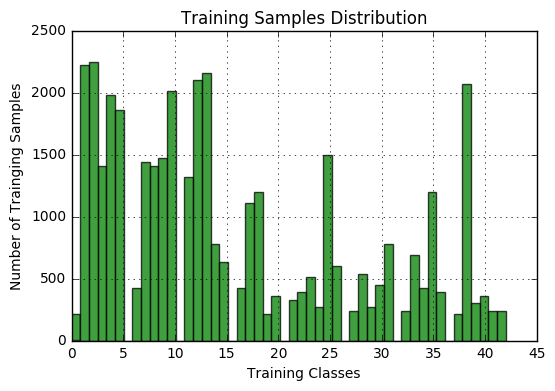

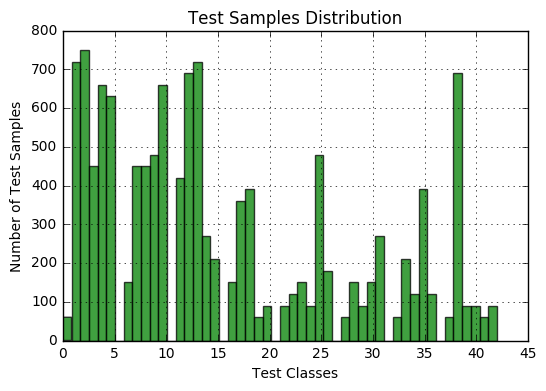

In [4]:
# Show the distribution of classes in the training and test sets
# the histogram of the data
plt.figure(1)
n, bins, patches = plt.hist(y_train, 50, facecolor='green', alpha=0.75)

plt.xlabel('Training Classes')
plt.ylabel('Number of Trainging Samples')
plt.title('Training Samples Distribution')
plt.grid(True)

plt.figure(2)
n, bins, patches = plt.hist(y_test, 50, facecolor='green', alpha=0.75)

plt.xlabel('Test Classes')
plt.ylabel('Number of Test Samples')
plt.title('Test Samples Distribution')
plt.grid(True)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [238]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
from skimage.morphology import skeletonize
from skimage.filters import roberts, sobel, scharr, prewitt

def denoise_img(image):
    return cv2.fastNlMeansDenoisingColored(image,None,10,3,7)

def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def convert_to_value(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2]

def edge(image):
    return sobel(image)

def equalize(image):
    img = np.copy(image)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
    if len(image.shape) > 2:
        dims = 3
        for i in range(dims):
            img[:,:,i] = clahe.apply(image[:,:,i])
    else:
        img = clahe.apply(image)
    return img

def YUV_equalize(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv = equalize(img_yuv)
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def preprocess(image):
    return denoise_img(image)
#     return denoise_img(equalize(img_gradient(deconvolve(convert_to_value(image)))))

In [239]:
import time
from tqdm import tqdm
def preprocess_batch(images):
    imgs = np.copy(images[:,:,:,0])
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess(images[i])
    return imgs

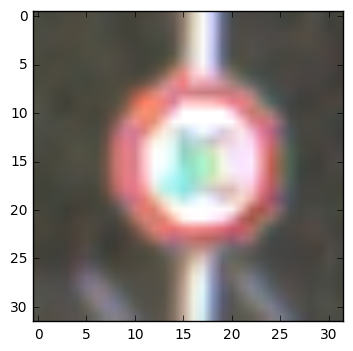

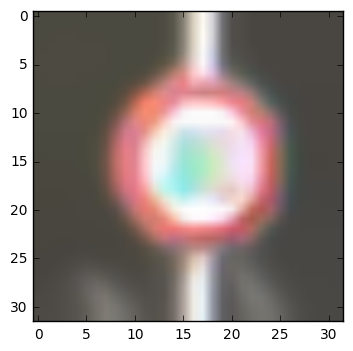

In [240]:
# Test preprocessing algorithm on one image
plt.figure(1)
plt.imshow(X_train[1230])
plt.figure(2)
plt.imshow(preprocess(X_train[1230]))
plt.show()

In [11]:
X_train_processed = preprocess_batch(X_train)

100%|██████████| 39209/39209 [00:51<00:00, 766.73it/s]


In [12]:
X_test_processed = preprocess_batch(X_test)

100%|██████████| 12630/12630 [00:16<00:00, 765.00it/s]


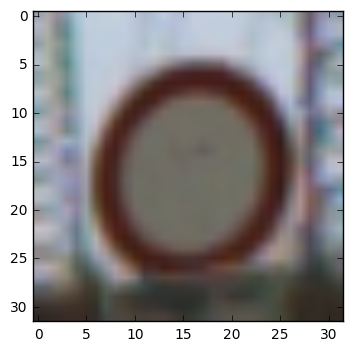

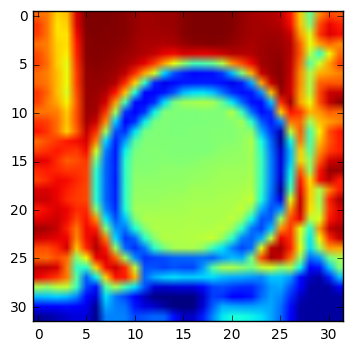

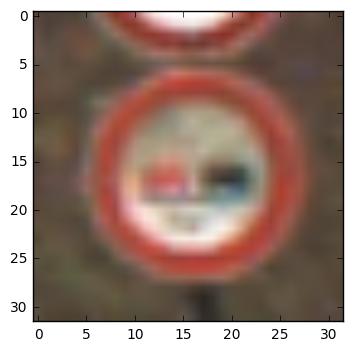

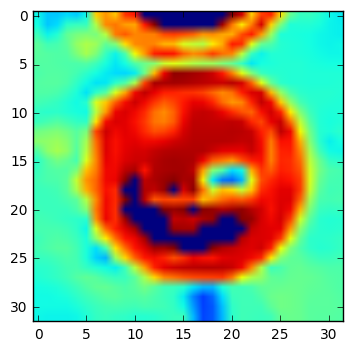

In [13]:
# Check to see if preprocessing was successful
# Pick a random image from each dataset
plt.figure(1)
plt.imshow(X_train[23266])

plt.figure(2)
plt.imshow(X_train_processed[23266])

plt.figure(3)
plt.imshow(X_test[342])

plt.figure(4)
plt.imshow(X_test_processed[342])

plt.show()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
The main objective in preprocessing the image data is to reduce the data dimensionality to assist the speed of the training as well as emphasize and better define features potentially useful for the neural network. My preprocessing algorithm followed a few simple steps:
* Image equalization for each color channel (RGB)
* Image denoising

*Note about color*: Color images have 3 channels and thus add 3 times the amount of data per sample. Converting each image to grayscale reduces the overall dimensionality by 1/3. Of course, with grayscale color data is removed and replacement by a concept of being somewhere on the spectrum from white to black. However, street signs use color extensively. Because of this, I opted to keep the color information within the images.

*Image Equalization*: Because the dataset has images of the same type of sign but in different lighting conditions it is important to reduce the variablity this causes. Equalizing the pixel values across an image helps reduce the amount of over or under saturation in an image. This then provides for more controlled imaging samples for the network to learn from. Because equalization can only be done on a 2-dimensional matrix, I ran the algorithm on each of the separate red, green, and blue channels.

*Image Denoising*: Various lighting conditions, relative clarity of the sign, and camera artifacts led to a high degree of noise to be present in some images. Denoising the images smooths out the pixel values thereby reducing bias from being introduced in the neural network. Denoising also helps to refine the shapes present in the images.


100%|██████████| 2/2 [00:00<00:00, 7550.50it/s]


[ 2.  2.  1.  1.]


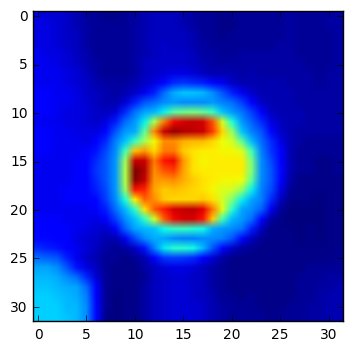

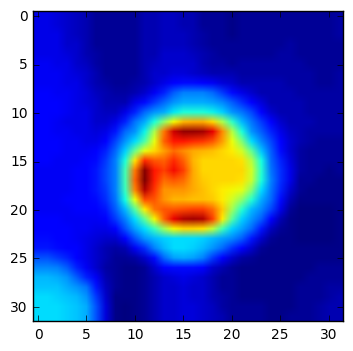

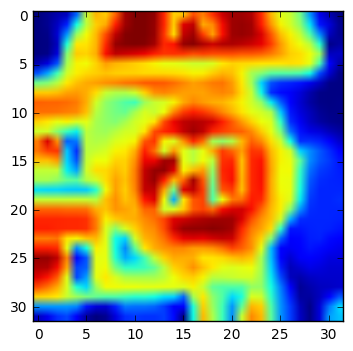

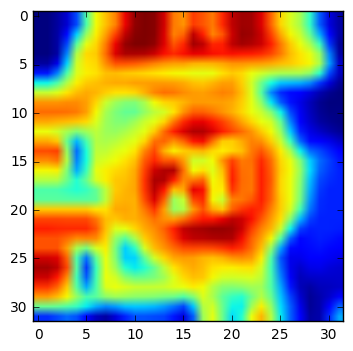

In [17]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
# Since some classes have significantly less data than others
# I decided to take each image and add one additional image
# 1. adding blur
def add_blur(image):
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(image,-1,kernel)

def make_more_data(images, labels):
    more_imgs = np.zeros((images.shape[0]*2, images.shape[1], images.shape[2]))
    more_labels = np.zeros((labels.shape[0]*2))
    for i in tqdm(range(images.shape[0])):
        more_imgs[2*i] = images[i]
        more_imgs[2*i+1] = add_blur(images[i])
        more_labels[2*i:2*i+2] = labels[i]
    return np.uint8(more_imgs), more_labels

# Test data augmentation
images, labels = make_more_data(np.array([X_train_processed[13004],X_train_processed[1]]),np.array([2,1]))
print(labels)
plt.figure(1)
plt.imshow(images[0])
plt.figure(2)
plt.imshow(images[1])
plt.figure(3)
plt.imshow(images[2])
plt.figure(4)
plt.imshow(images[3])
plt.show()


In [18]:
X_train_augment, y_train_augment = make_more_data(X_train_processed, y_train)

100%|██████████| 39209/39209 [00:01<00:00, 29926.86it/s]


In [19]:
# Check that data augmentation worked
print(X_train.shape, X_train_augment.shape)
print(y_train.shape, y_train_augment.shape)

(39209, 32, 32, 3) (78418, 32, 32)
(39209,) (78418,)


In [241]:
from sklearn.cross_validation import train_test_split
# We will use 80% for training and 20% for validation
def split_data(x, y):
    data_train, data_valid, labels_train, labels_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    print("Shape of training examples = ", data_train.shape)
    print("Shape of validation examples = ", data_valid.shape)
    return data_train, data_valid, labels_train, labels_valid

x_train, x_valid, train_labels, valid_labels = split_data(X_train, y_train)

Shape of training examples =  (31367, 32, 32, 3)
Shape of validation examples =  (7842, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
Prior to performing any splits in the datasets both the original training and testing datasets were put through the preprocessing algorithm. Then, I decided to add additional data across the entire dataset. Based on the histograms plotted earlier, about half of the classes in the dataset had significantly lower samples than the others. Adding more data to train and test on will serve to make the network more generalizable. Additional images were created by taking the original image and adding a median blur to it.

For my first approach I used a standard cross validation approach where from the original training dataset I kept 80% for training and reserved the remaining 20% for validation. I also kept the original testing dataset without modification.

In [245]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# Prepare data
import tensorflow as tf
from six.moves import range

# accuracy function to use throughout training
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

image_size = 32
num_labels = np.unique(y_test).shape[0]
num_channels = 3 # RGB

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(x_train, train_labels)
valid_dataset, valid_labels = reformat(x_valid, valid_labels)
test_dataset, test_labels = reformat(X_test, y_test)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (31367, 32, 32, 3) (31367, 1, 43)
Validation set (7842, 32, 32, 3) (7842, 1, 43)
Test set (12630, 32, 32, 3) (12630, 43)


In [246]:
# Create tensorflow network
batch_size = 64
patch_size = 5
depth = 64
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  global_step = tf.Variable(0, name="global_step")
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1), name="layer1_weights")
  layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1), name="layer2_weights")
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="layer2_biases")
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1), name="layer3_weights")
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="layer3_biases")
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1), name="layer4_weights")
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name="layer4_biases")
  
  saver = tf.train.Saver()

  # Model.
  def model(data):
    # 1st Convolution
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer1_biases)
    # Max pooling of activation
    hidden_pooled = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    # Local normalization
    normalized = tf.nn.local_response_normalization(hidden_pooled)
    # 2nd Convolution
    conv = tf.nn.conv2d(normalized, layer2_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer2_biases)
    # Local normalization
    normalized = tf.nn.local_response_normalization(hidden)
    # Max pooling
    hidden_pooled = tf.nn.max_pool(normalized, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    shape = hidden_pooled.get_shape().as_list()
    reshape = tf.reshape(hidden_pooled, [shape[0], shape[1] * shape[2] * shape[3]])
    # 1st fully connected layer with relu activation
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    # 2nd fully connected layer
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  global_step,  # Current index into the dataset.
  batch_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
  # Use simple momentum for the optimization.
  optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**

In [244]:
# Train model
num_steps = 4501

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
#   tf.initialize_all_variables().run()
#   saver.restore(session, "/Users/michaelwransky/Documents/SDCND/traffic-signs/trained_weights/model.ckpt")
#   print('Model restored with latest weights')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  # Save the variables to disk.
  save_path = saver.save(session, "/Users/michaelwransky/Documents/SDCND/traffic-signs/trained_weights/model.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 4.739341
Minibatch accuracy: 3.1%
Validation accuracy: 5.2%
Minibatch loss at step 100: 3.109972
Minibatch accuracy: 18.8%
Validation accuracy: 26.4%
Minibatch loss at step 200: 1.827792
Minibatch accuracy: 50.0%
Validation accuracy: 45.7%
Minibatch loss at step 300: 1.294502
Minibatch accuracy: 67.2%
Validation accuracy: 62.5%
Minibatch loss at step 400: 0.727859
Minibatch accuracy: 81.2%
Validation accuracy: 77.1%
Minibatch loss at step 500: 0.699162
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Minibatch loss at step 600: 0.386534
Minibatch accuracy: 92.2%
Validation accuracy: 87.9%
Minibatch loss at step 700: 0.270166
Minibatch accuracy: 96.9%
Validation accuracy: 89.4%
Minibatch loss at step 800: 0.358234
Minibatch accuracy: 90.6%
Validation accuracy: 90.9%
Minibatch loss at step 900: 0.372948
Minibatch accuracy: 92.2%
Validation accuracy: 91.5%
Minibatch loss at step 1000: 0.224785
Minibatch accuracy: 93.8%
Validation accuracy: 94.3%
M

/Users/michaelwransky/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Test accuracy: 0.0%
Model saved in file: /Users/michaelwransky/Documents/SDCND/traffic-signs/trained_weights/model.ckpt


In [247]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  saver.restore(session, "/Users/michaelwransky/Documents/SDCND/traffic-signs/trained_weights/model.ckpt")
  print('Model restored with latest weights')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Model restored with latest weights
Test accuracy: 92.2%


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

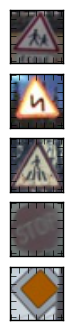

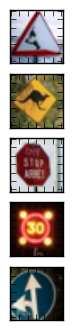

In [270]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# load 10 test images
from skimage import io
test_imgs = np.uint8(np.zeros((10,32,32,3)))
for i in range(1,11):
    image = io.imread('/Users/michaelwransky/Documents/SDCND/traffic-signs/test_images/test{}.jpg'.format(str(i)))
    test_imgs[i-1] = image

test_img_data = test_imgs.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)

f, axarr = plt.subplots(5, 1)
for i in range(5):
    axarr[i].imshow(test_imgs[i])
    plt.setp(axarr[i].get_xticklabels(), visible=False)
    plt.setp(axarr[i].get_yticklabels(), visible=False)
f, axarr2 = plt.subplots(5, 1)
for i in range(5,10):
    axarr2[i-5].imshow(test_imgs[i])
    plt.setp(axarr2[i-5].get_xticklabels(), visible=False)
    plt.setp(axarr2[i-5].get_yticklabels(), visible=False)
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chose ten candidate images to test the classifier. These images were selected using a combination of Google Street Views and stock photography. See above for each of the ten images. Below is a table outlining which image is which sign.

|Test Image|Sign|
|:---------|:-------|
|1|Children Crossing|
|2|Road Narrows on Right|
|3|Pedestrian Crossing|
|4|Stop|
|5|Priority Road|
|6|Slippery Road|
|7|Kangaroo Crossing|
|8|Stop Sign|
|9|Speed Limit (30 km/h)
|10|Ahead or Left Only|

Each of these ten images hold potential challenges for the classifier:
- Image 1: Included in the image is text related to the street name. This could potentially confuse the classifier and make it more biased towards classifying it as a sign with numbers/letters rather than a sign with an icon.
- Image 2: This sign is taken at night and is at a low resolution due to the distance the sign was at.
- Image 3: This sign is rusted and uses an outdated design, so the classifier has not seen this example before.
- Image 4: This sign is rotated and blurred.
- Image 5: Part of this sign is obscurred by a pole.
- Image 6: Part of this sign is obscurred by snow.
- Image 7: This sign has never been seen by the classifier since it belongs to a separate continent, and the training dataset does not have animal crossing signs that are yellow diamonds with an icon.
- Image 8: This sign has three different languages on it.
- Image 9: This is a lit-up sign at night that is very different than the daytime sign.
- Image 10: This sign is slightly rotated and uncentered.

In [260]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session(graph=graph) as session:
  saver.restore(session, "/Users/michaelwransky/Documents/SDCND/traffic-signs/trained_weights/model.ckpt")
  print('Model restored with latest weights')
  data_placeholder = tf.placeholder(tf.float32, [10, 32, 32, 3])
  predictions = tf.nn.softmax(model(data_placeholder))
  pred_vals = session.run(predictions, feed_dict={data_placeholder: test_img_data})
  top_k = session.run(tf.nn.top_k(pred_vals, 5, sorted=True))
  print("Predicted Labels")
  print(np.argmax(pred_vals, 1))

Model restored with latest weights
Predicted Labels
[11 11  1 13 12 25  2 14 14 35]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Below is a table comparing the predicted sign type with the actual sign type.

|Test Image|Predicted Sign|True Sign|
|:---------|:-------------|:-------|
|1|Right-of-way at Next Intersection|Children Crossing|
|2|Right-of-way at Next Intersection|Road Narrows on Right|
|3|Speed Limit (30km/h)|Pedestrian Crossing|
|4|Yield|Stop|
|5|Priority|Priority Road|
|6|Road Work|Slippery Road|
|7|Speed Limit (50km/h)|Kangaroo Crossing|
|8|Stop Sign|Stop Sign|
|9|Stop Sign|Speed Limit (30 km/h)
|10|Ahead Only|Ahead or Left Only|

The model performs at an awful 20% accuracy rate. This is markedly different than the 92.2% accuracy rate achieved using testing samples from the original dataset.

In [265]:
# Pull out values and indices for top 5 softmax probability analysis
top_k_values = top_k[0]
top_k_indices = top_k[1]

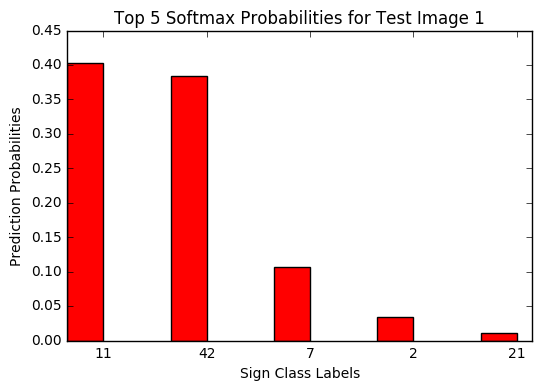

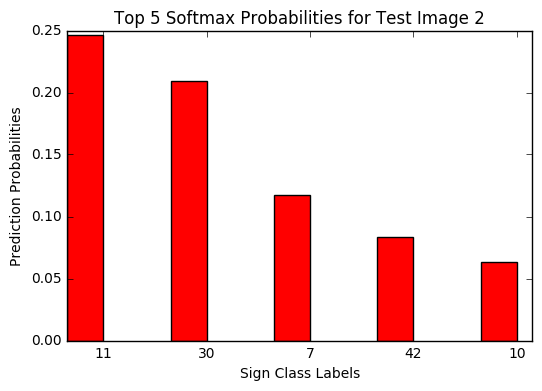

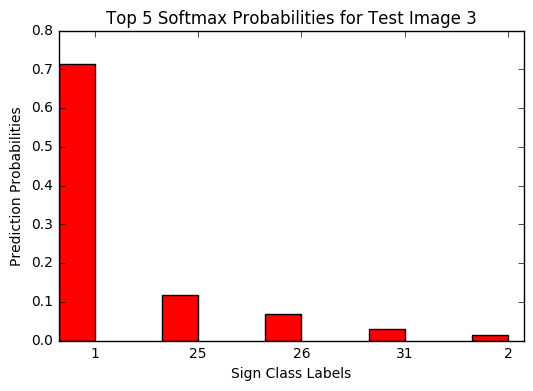

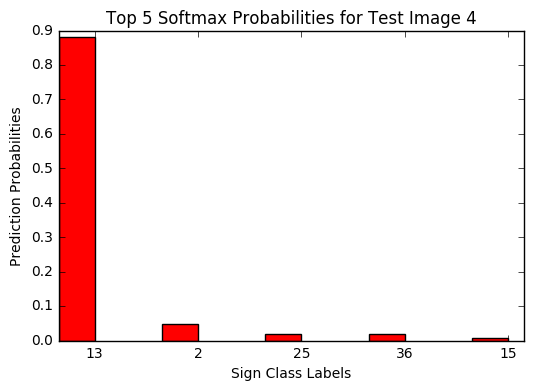

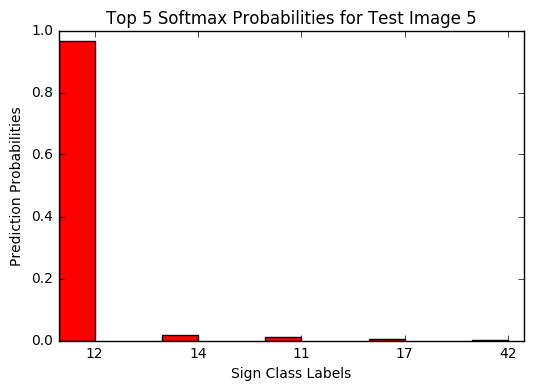

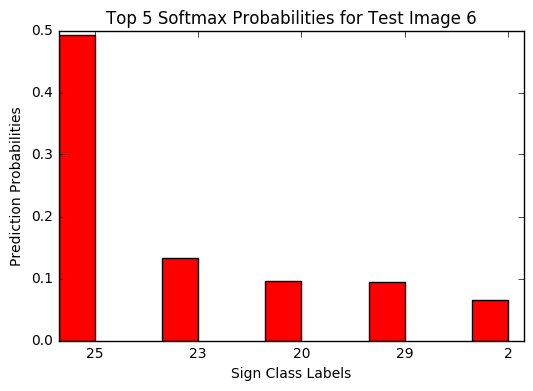

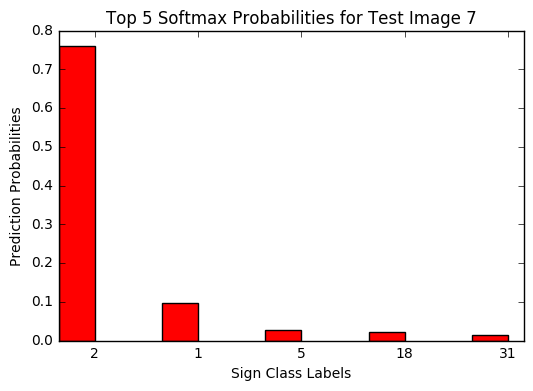

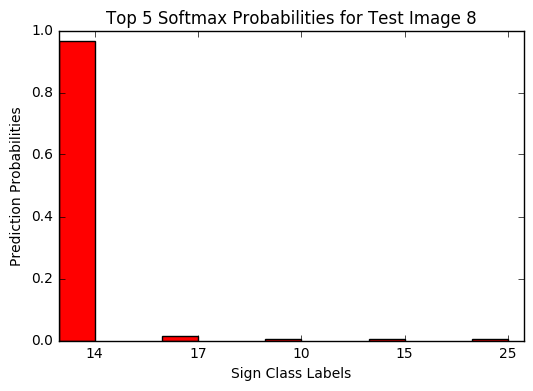

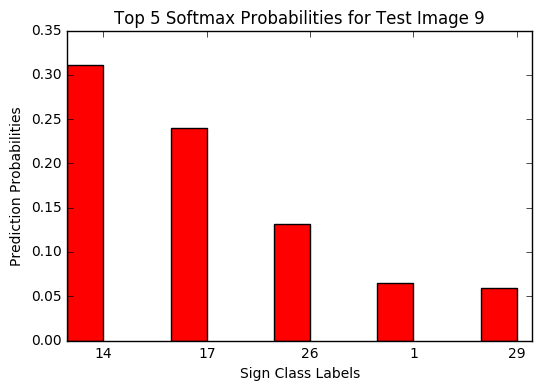

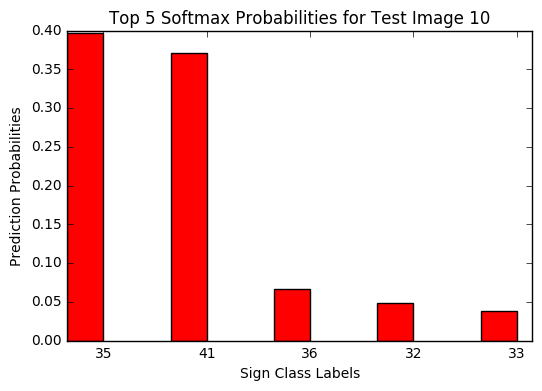

In [269]:
### Visualize the softmax probabilities
N = 5

ind = np.arange(N)  # the x locations for the values
width = 0.35       # the width of the bars

for i in range(10):
    plt.figure(i)
    values = top_k_values[i]
    plt.bar(ind, values, width, color='r')
    plt.ylabel('Prediction Probabilities')
    plt.xlabel('Sign Class Labels')
    plt.title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    plt.xticks(ind+width, tuple(top_k_indices[i]))

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

|Test Image|Certainty Level|True Sign in Top 5 Probabilities|
|:---------|:-------------|:-------|
|1|~40%|No|
|2|~25%|No|
|3|~70%|No|
|4|~90%|No|
|5|~95%|Yes|
|6|~50%|Yes|
|7|~78%|Yes|
|8|~95%|Yes|
|9|~32%|Yes|
|10|~40%|No|

As can be seen from the above bar charts, the model ranges from predictions of high certainty (nearly 100% certainty) to very uncertain predictions where the maximum probability is only 25%. There is a pattern in terms of which types of signs yield the highest certainty. Signs with a large portion colored red or yellow (such as a stop or priority road sign) lead to more certain predictions. Signs where the color is more dispersed, such as a sign with a red border, white interior, and a black icon, lead to very uncertain predicitions. This seems reasonable because signs with more visual information on them in the form of icons tend be harder to distinguish given low resolution images. Since most of these icons would largely be characterized by edges, a 32x32 image makes identifying those edges nearly impossible.

Interestingly, 50% of the test images had the correct sign type in the top 5 softmax probabilities. However, when this was the case the actual sign type had a marginal probability at times less than 5%. For some of the signs that had icons on it, such as the pedestrian and children crossing signs, the true sign type was not in the top 5 probabilities, but a similar sign was. So, for example, if the sign was a pedestrian crossing the top 5 probabilities would include a children crossing sign. This suggests that the model has a great degree of difficulty interpretting these icons and making them unique across the different sign types.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.